In [1]:
import os

In [2]:
import xarray as xr
import pandas as pd
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
import dask_labextension

In [3]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.124:42027 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.124:42027,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1, "time":-1, "depth":2},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [11]:
CM4Xp25_historical = read_CM4X("CM4Xp25_historical_transient_tracers.zarr")
CM4Xp25_ssp585 = read_CM4X("CM4Xp25_ssp585_transient_tracers.zarr")
CM4Xp25_piControl = read_CM4X("CM4Xp25_piControl_transient_tracers.zarr")

In [22]:
point_historical = CM4Xp25_historical.cfc12.sel(yh = -60, xh = -180, method = "nearest").compute()
# point_PiControl = CM4Xp25_piControl.sel(yh = -70, xh = -180, method = "nearest").compute()
point_ssp585 = CM4Xp25_ssp585.cfc12.sel(yh = -60, xh = -180, method = "nearest").compute()

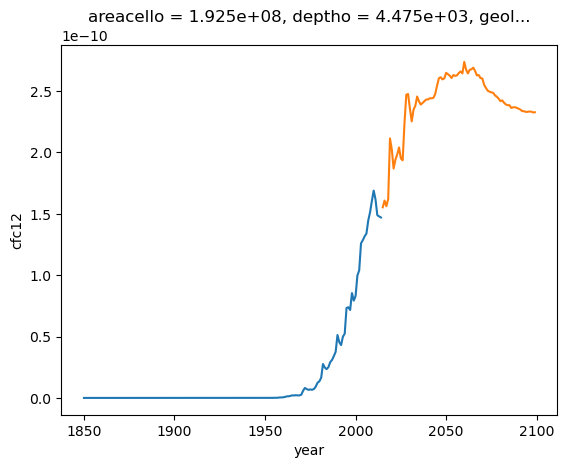

In [23]:
fig, ax = plt.subplots()
point_historical.isel(zl = 65).plot(ax = ax, label = "historical")
point_ssp585.isel(zl = 65).plot(ax = ax, label = "PiControl")

Warning: CFCs are probably given in mol / m3. To compare to obs, need to change units to picomol / kg. Can use m = \rho * V i.e. need to divide by the density of the grid cell. This is a approximately a scaling of 10^9. 

In [62]:
cfc12_2015_historical = compute_depth_average(CM4Xp25_historical, 3000, 4000).isel(year = -1).compute()
cfc12_2015_ssp585 = compute_depth_average(CM4Xp25_ssp585, 3000, 4000).isel(year = -1).compute()

Exception ignored in: <generator object sync.<locals>.f at 0x2aac1616b530>
Traceback (most recent call last):
  File "/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/utils.py", line 391, in f
    result = yield future
KeyboardInterrupt: 

KeyboardInterrupt



In [63]:
import numpy as np

In [126]:
historical_zonal = CM4Xp25_historical.mean(["xh"]).isel(year = -1).compute()
ssp585_zonal = CM4Xp25_ssp585.mean(["xh"]).isel(year = -1).compute()

In [102]:
zl, yh = np.meshgrid(historical_zonal.zl, historical_zonal.yh)

In [139]:
np.nanmax(X)

1.5918402e-09

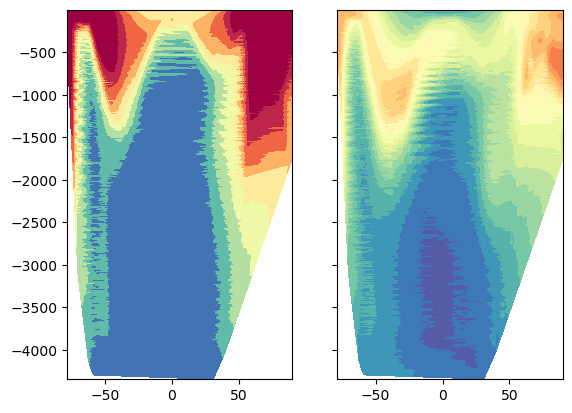

In [149]:
fig, ax = plt.subplots(1, 2, sharey = True)
import numpy.ma as ma

z = historical_zonal.z.values
Zm = z[~np.isnan(z)][:]
Ym = yh[~np.isnan(z)][:]
X = historical_zonal.cfc12.values.T[~np.isnan(z)][:]

ax[0].tricontourf(Ym, Zm, 1e9 * X, cmap = "Spectral_r", levels = 15, vmin = 0, vmax = 2); 

z = ssp585_zonal.z.values
Zm = z[~np.isnan(z)][:]
Ym = yh[~np.isnan(z)][:]
X = ssp585_zonal.cfc12.values.T[~np.isnan(z)][:]

ax[1].tricontourf(Ym, Zm, 1e9 * X, cmap = "Spectral_r", levels = 15, vmin = 0, vmax = 2); 

# ssp585_zonal.plot(ax = ax[0], add_colorbar = False)

# ax[0].invert_yaxis()

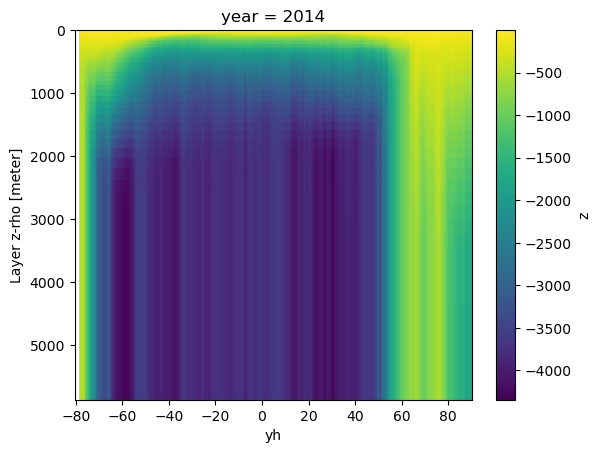

In [156]:
fig, ax = plt.subplots()
historical_zonal.z.T.plot(ax = ax); ax.invert_yaxis()

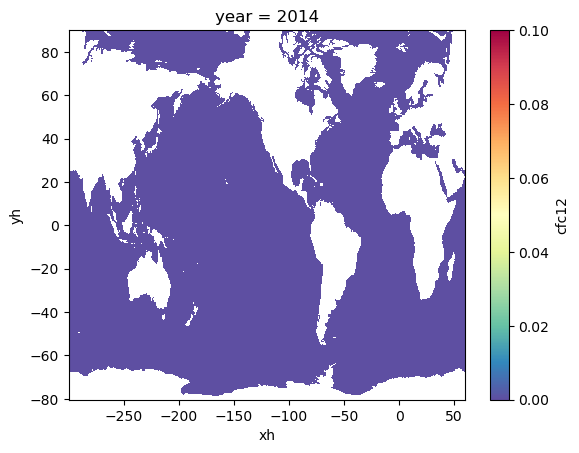

In [38]:
(cfc12_2015_historical).plot(vmin = 0, vmax = 0.1, cmap = "Spectral_r")

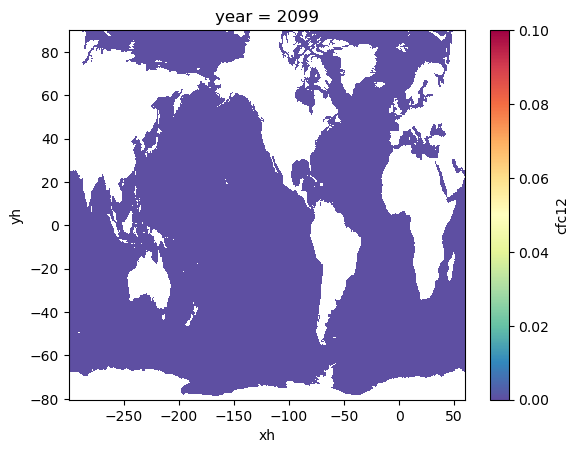

In [40]:
(cfc12_2015_ssp585).plot(vmin = 0, vmax = 0.1, cmap = "Spectral_r")

In [26]:
ds_mean= ds.sel(zl = slice(2000, 5000)).mean(["zl", "year"]).cfc12.compute()

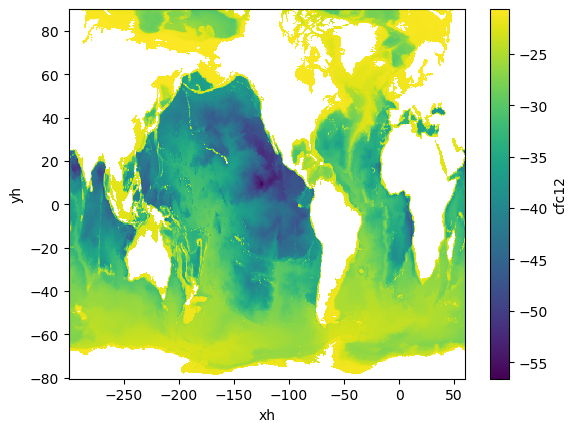

In [35]:
np.log(np.abs(ds_mean)).plot()